# Predicting video memorability using captions (Jointly)

## 1. Loading the captions and the memorability scores

In [1]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/stone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [3]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
#cap_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
cap_path = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

# load the ground truth values
label_path = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/ground-truth/'
labels=pd.read_csv(label_path+'ground-truth_dev-set.csv')

In [4]:
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


In [5]:
df_cap.head()

,video,caption
0,video10.webm,couple relaxing on picnic crane shot
1,video100.webm,cute black and white cats in cage at animal sh...
2,video10000.webm,owl in tree close up
3,video10001.webm,around the house on a laptop
4,video10002.webm,beautiful young girl with apple


## 2. Preprocessing the captions for model inputs
### Separate words and count each word's occurrence

### Maping each unique word to an integer (one-hot encoding)

In [6]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)

In [7]:
tokenizer.fit_on_texts(list(df_cap.caption.values))

In [8]:
one_hot_res = tokenizer.texts_to_matrix(list(df_cap.caption.values),mode='binary')
sequences = tokenizer.texts_to_sequences(list(df_cap.caption.values))

In [9]:
len_token

5874

In [10]:
one_hot_res

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [11]:
sequences[:2]
len(sequences)

8000

## Making them the same length by padding zeros

In [12]:
# calculating max length
max_len = 50

### Making sequences index same length

In [13]:
X_seq = np.zeros((len(sequences),max_len))
for i in range(len(sequences)):
    n = len(sequences[i])
    if n==0:
        print(i)
    else:
        X_seq[i,-n:] = sequences[i]
X_seq

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 5.970e+02, 3.470e+02,
        2.500e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 9.000e+00, 4.100e+02,
        4.110e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.900e+01, 2.300e+01,
        1.900e+01],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.869e+03, 5.870e+03,
        5.871e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.740e+02,
        7.100e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 8.000e+00, 5.873e+03,
        9.190e+02]])

### Making one-hot encoding the same size

In [14]:
# it is already the same size

# 3. Building network model
## Split data set to training and test data
## Prediction with indices

In [15]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = X_seq

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [17]:
# add dropout
# add regularizers
model = Sequential()
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

In [18]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

In [19]:
# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 0s 73us/step - loss: 0.3472 - acc: 0.6342 - val_loss: 0.3894 - val_acc: 0.6950
Epoch 2/20
6400/6400 [==============================] - 0s 43us/step - loss: 0.2573 - acc: 0.6339 - val_loss: 0.2539 - val_acc: 0.6950
Epoch 3/20
6400/6400 [==============================] - 0s 43us/step - loss: 0.1719 - acc: 0.6497 - val_loss: 0.1088 - val_acc: 0.6956
Epoch 4/20
6400/6400 [==============================] - 0s 46us/step - loss: 0.1070 - acc: 0.6709 - val_loss: 0.0684 - val_acc: 0.6925
Epoch 5/20
6400/6400 [==============================] - 0s 46us/step - loss: 0.0630 - acc: 0.6755 - val_loss: 0.0491 - val_acc: 0.6887
Epoch 6/20
6400/6400 [==============================] - 0s 45us/step - loss: 0.0439 - acc: 0.6836 - val_loss: 0.0362 - val_acc: 0.6875
Epoch 7/20
6400/6400 [==============================] - 0s 43us/step - loss: 0.0322 - acc: 0.6900 - val_loss: 0.0267 - val_acc: 0.6925
Epoch 8

## Visualizing the validation and training loss

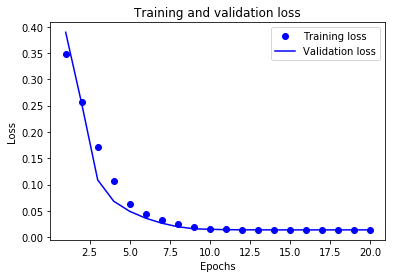

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

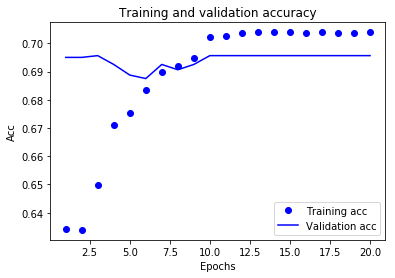

In [21]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


# Predicting video memorability using captions (one-hot res)

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 1s 148us/step - loss: 0.0823 - acc: 0.5070 - val_loss: 0.0315 - val_acc: 0.6956
Epoch 2/20
6400/6400 [==============================] - 1s 101us/step - loss: 0.0315 - acc: 0.5800 - val_loss: 0.0152 - val_acc: 0.6956
Epoch 3/20
6400/6400 [==============================] - 1s 99us/step - loss: 0.0209 - acc: 0.6658 - val_loss: 0.0142 - val_acc: 0.6956
Epoch 4/20
6400/6400 [==============================] - 1s 95us/step - loss: 0.0186 - acc: 0.6923 - val_loss: 0.0140 - val_acc: 0.6956
Epoch 5/20
6400/6400 [==============================] - 1s 97us/step - loss: 0.0168 - acc: 0.7014 - val_loss: 0.0139 - val_acc: 0.6956
Epoch 6/20
6400/6400 [==============================] - 1s 95us/step - loss: 0.0159 - acc: 0.7039 - val_loss: 0.0139 - val_acc: 0.6956
Epoch 7/20
6400/6400 [==============================] - 1s 97us/step - loss: 0.0153 - acc: 0.7039 - val_loss: 0.0139 - val_acc: 0.6956
Epoch

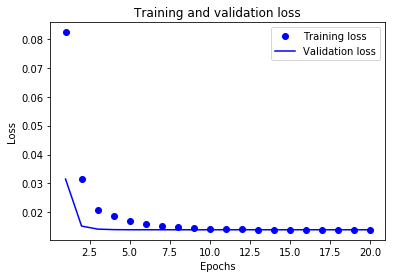

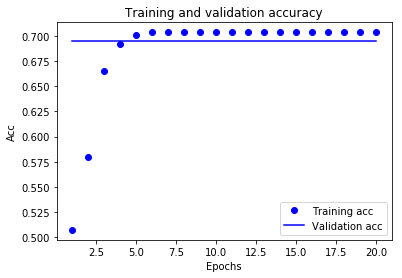

In [24]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# add dropout
# add regularizers
model = Sequential()
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(len_token,)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()